# Lab Assignment Two: Exploring Image Data
Machine Learning in Python<br/>
Diogo Benetti Faé Rodrigues<br/>
Alex Shockley<br/>
Jay Kynerd<br/>
02/21/2023

**[2 points] Give an overview of the dataset. Describe the purpose of the data set you selected (i.e., why was this data collected in the first place?). What is the prediction task for your dataset and which third parties would be interested in the results? Why is this data important? Once you begin modeling, how well would your prediction algorithm need to perform to be considered useful to the identified third parties? Be specific and use your own words to describe the aspects of the data.**

## Business Understanding

Business Understanding ...

**[.5 points] Read in your images as numpy arrays. Resize and recolor images as necessary.<br/>
[.4 points] Linearize the images to create a table of 1-D image features (each row should be one image).<br/>
[.1 points] Visualize several images.**

## Data Preparation

First step is always to load in the dataset. In this notebook, we are working with the Stanford Dogs Dataset. With the data stored, we can visualize some images and explore the different dog breeds available.

In [ ]:
# Visualize some images

Before we start with some Data Reduction techniques, we must first prepare the data so it is ready to be used. The first step is to read the images as numpy arrays. While reading the images, we can also linearize them to become a 1D array, which will improve the algorithms' accuracy.

In [137]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# plt.imshow(dog_array)
# Takes about 50 seconds to run

data = pd.DataFrame(columns=['Target'])
images = []
labels = []
dogs = []
breeds_folders = os.listdir(f'{os.getcwd()}/Images')
print(f"Number of Breeds: {len(breeds_folders)}")

loop_counter = 0
for breed in os.listdir(f'{os.getcwd()}/Images'):
    curr_breed = breed.split('-', 1)[1]
    # print(curr_breed)
    for image in os.listdir(f'{os.getcwd()}/Images/{breed}'):
        dog = cv2.imread(f'{os.getcwd()}/Images/{breed}/{image}')
        dog_array = np.array(dog)
        dog_series = np.ravel(dog_array)
        # print(data)
        # print(len(data))
        # data = pd.concat([data, dog_series], axis=1)
        # data.insert(value=dog_series, column=)
        # data.join(dog_series, ignore_index=True)
        # data.loc[len(data)] = dog_series
        dogs.append(dog)
        images.append(dog_series)
        labels.append(curr_breed)
        # data = data.append(dog_series, ignore_index=True)
        # data["Target"] = curr_breed

X = np.array(images)
y = np.array(labels)

Number of Breeds: 120


/var/folders/bt/wb3yymln7ddb5524t119715m0000gn/T/ipykernel_92577/141361824.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(images)


In [135]:
# height, width, channels = dog.shape
        # print("The resolution of the image is {} x {}".format(width, height))
        # data.loc[len(data)] = dog_array
# print(f"Total Number of Images: {data}")

Below we can compare how the picture of a Maltese is stored as a numpy array.

[226 217 213 ... 216 208 201]
silky_terrier


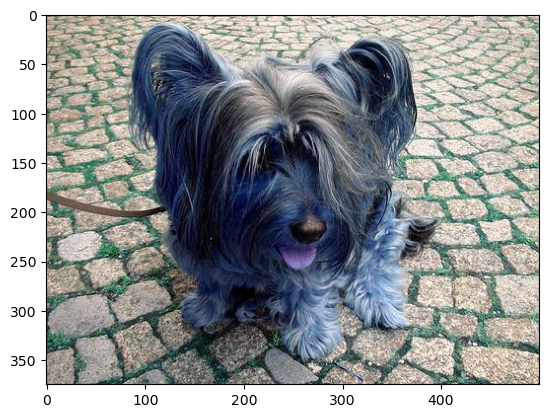

In [143]:
print(X[0])
print(y[0])
plt.imshow(dogs[2])

**[.5 points] Perform linear dimensionality reduction of the images using principal components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.<br/>
[.5 points] Perform linear dimensionality reduction of your image data using randomized principle components analysis. Visualize the explained variance of each component. Analyze how many dimensions are required to adequately represent your image data. Explain your analysis and conclusion.<br/>
[2 points]  Compare the representation using PCA and Randomized PCA. The method you choose to compare dimensionality methods should quantitatively explain which method is better at representing the images with fewer components.  Do you prefer one method over another? Why?<br/>
[1 points] Perform feature extraction upon the images using any feature extraction technique (e.g., gabor filters, ordered gradients, DAISY, etc.).<br/>
[2 points] Does this feature extraction method show promise for your prediction task? Why? Use visualizations to analyze this questions. For example, visualize the differences between statistics of extracted features in each target class. Another option, use a heat map of the pairwise differences (ordered by class) among all extracted features. Another option, build a nearest neighbor classifier to see actual classification performance.**

## Data Reduction

**[1 point] Perform feature extraction upon the images using DAISY. Rather than using matching on the images with the total DAISY vector, you will instead use key point matching. You will need to investigate appropriate methods for key point matching using DAISY. NOTE: this often requires some type of brute force matching per pair of images, which can be computationally expensive.**

## Exceptional Work